# Input Interventions Analysis

In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import torch
import numpy as np
from casadi import *
import cvxpy as cp
from tqdm.notebook import tqdm
from torch import nn
from pytope import Polytope
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
import time
from multiprocessing import Pool
import os
from tqdm.notebook import tqdm
from apcbf.approximator import *
from apcbf.controller import *
import apcbf.simulation as sim
from apcbf.dynamic import *
from apcbf.controller import *
from apcbf.nn_model_types import NonLinModelType
from apcbf.non_lin_sys import *
from apcbf.approximate_pcbf_nonlinear import *
from apcbf.pcbf_nonlinear import *

In [2]:
np.random.seed(0)

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
constraint_color = (0, 120.0/256, 148.0/256)

In [4]:
def return_interventions(x_sim, u_sim, ctrl):
    u_p = np.empty_like(u_sim)
    have_no_intervention = np.zeros_like(u_sim)
    norm_dev = np.zeros(u_sim.shape[0])
    for i, x_el in enumerate(x_sim):
        if i == len(x_sim) - 1:
            break
        u_p[i,:] = ctrl.input(x_el.reshape(4,1)).flatten()
        have_no_intervention[i,:] = np.abs(u_p[i,:] - u_sim[i,:]) < 1e-6 # np.isclose(u_p[i,:], u_sim[i,:])
        norm_dev[i] = np.linalg.norm(u_p[i,:] - u_sim[i,:])
    have_intervention = np.logical_not(have_no_intervention)
    num_intervention = np.sum(have_intervention, axis = 0)
    assert num_intervention.shape[0] == 2
    return have_intervention, have_no_intervention, num_intervention, u_p, norm_dev

### Initialize parameters and load NN model 

In [5]:
# TORCH_MODEL_NAME = '../models/model_nlup_NNplus_100_02_06_11_35.pt'
TORCH_MODEL_NAME = '../models/model_nlup_NNplus_100_04_06_13_54.pt'
# model_type_name = NonLinModelType.THREEHIDDENLAYERS
model_type_name = NonLinModelType.TWOHIDDENLAYERS
use_log_space_model = True
use_plus_models = True

In [6]:
LOG_NAME = TORCH_MODEL_NAME[21:-3]
LOG_NAME = LOG_NAME.replace("/","_")
print(LOG_NAME)

NNplus_100_04_06_13_54


In [7]:
model = torch.load(TORCH_MODEL_NAME, map_location=torch.device('cpu'))

In [8]:
def output_modifier(h) :
    return np.exp(h) - 1

In [9]:
sys = non_lin_disc
print(sys)
sys.input_dim

NonlinearDiscreteDynamics(
 f: <method-wrapper '__str__' of function object at 0x7eff666faca0>


2

In [10]:
N = 50
c = 0.001
mu_x = np.sqrt(0.001)
mu_u = np.sqrt(0.001)
alpha_f = 1000 
delta_i = lambda i : i*0.005 #as done in original paper

In [11]:
# load parameters values
params_dict = pickle.load(open( "../params/non_linear_termset_params.p", "rb" ))
params_dict

{'P_f': array([[ 1.05097272e+00,  5.47383181e+00,  2.80315280e+00,
         -8.55535683e-20],
        [ 5.47383181e+00,  3.16255265e+01,  1.67387432e+01,
         -5.12263033e-19],
        [ 2.80315280e+00,  1.67387432e+01,  9.36896767e+00,
         -2.92917364e-19],
        [-8.55535683e-20, -5.12263033e-19, -2.92917364e-19,
          2.05617580e-01]]),
 'K_f': array([[-3.58269824e-02, -1.66596318e+00, -1.83800159e+00,
         -3.76529061e-20],
        [ 1.14231034e-18,  6.21150136e-18,  3.17977562e-18,
         -9.06901475e-01]]),
 'gamma_x': 0.009936271172834462,
 'gamma_f': 0.9900637288271655,
 'alpha_f': 1000,
 'T_disc': 0.05}

#### Constraints

In [12]:
constraint_dict = pickle.load(open("../params/non_linear_constraints_params.p", 'rb'))
X = constraint_dict['X']
U = constraint_dict['U']

In [13]:
K = 0.01*np.ones((2,4))
bad_ctrl = LinearController(K)

In [14]:
learned_controller_maxdec = APCBFSafetyFilterMAXDEC(model = model,m_type = model_type_name, use_log_space_model = use_log_space_model, use_plus_model = use_plus_models, sys = non_lin_disc, params_dict=params_dict, input_constraints=U, performance_controller = bad_ctrl, verbose = False)

In [15]:
learned_controller_kinf = APCBFSafetyFilterKINFDEC(model = model,m_type = model_type_name, use_log_space_model=use_log_space_model, 
                                                   use_plus_model = use_plus_models, params_dict = params_dict, sys= sys, input_constraints = U, 
                                                   performance_controller = bad_ctrl, verbose = False, kinf_factor=0.5, zero_tol=1e-8)

In [16]:
pcbf_controller = Algorithm(non_lin_cont, bad_ctrl, X, U, delta_i, params_dict, N=50, verbose=False)

## Input trajectory intervention

In [17]:
# initial conditions and number of time steps
x0 = np.array([2,0.0, 0, 0])
N_steps = 250

In [18]:
x_safe_1, u_sim_1 = sim.simulate_discrete(x0, non_lin_disc, controller_object=pcbf_controller, Nsteps=N_steps)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [19]:
x_safe_max_1, u_sim_max_1 = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_maxdec, Nsteps=N_steps)

In [20]:
x_safe_kinf_1, u_sim_kinf_1 = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_kinf, Nsteps=N_steps)

In [21]:
_ , have_no_intervention, _ , u_p_1, norm_dev = return_interventions(x_safe_1, u_sim_1, bad_ctrl)
_ , have_no_intervention_max, _ , u_p_max_1, norm_dev_max = return_interventions(x_safe_max_1, u_sim_max_1, bad_ctrl)
_ , have_no_intervention_kinf, _ , u_p_kinf_1, norm_dev_kinf = return_interventions(x_safe_kinf_1, u_sim_kinf_1, bad_ctrl)

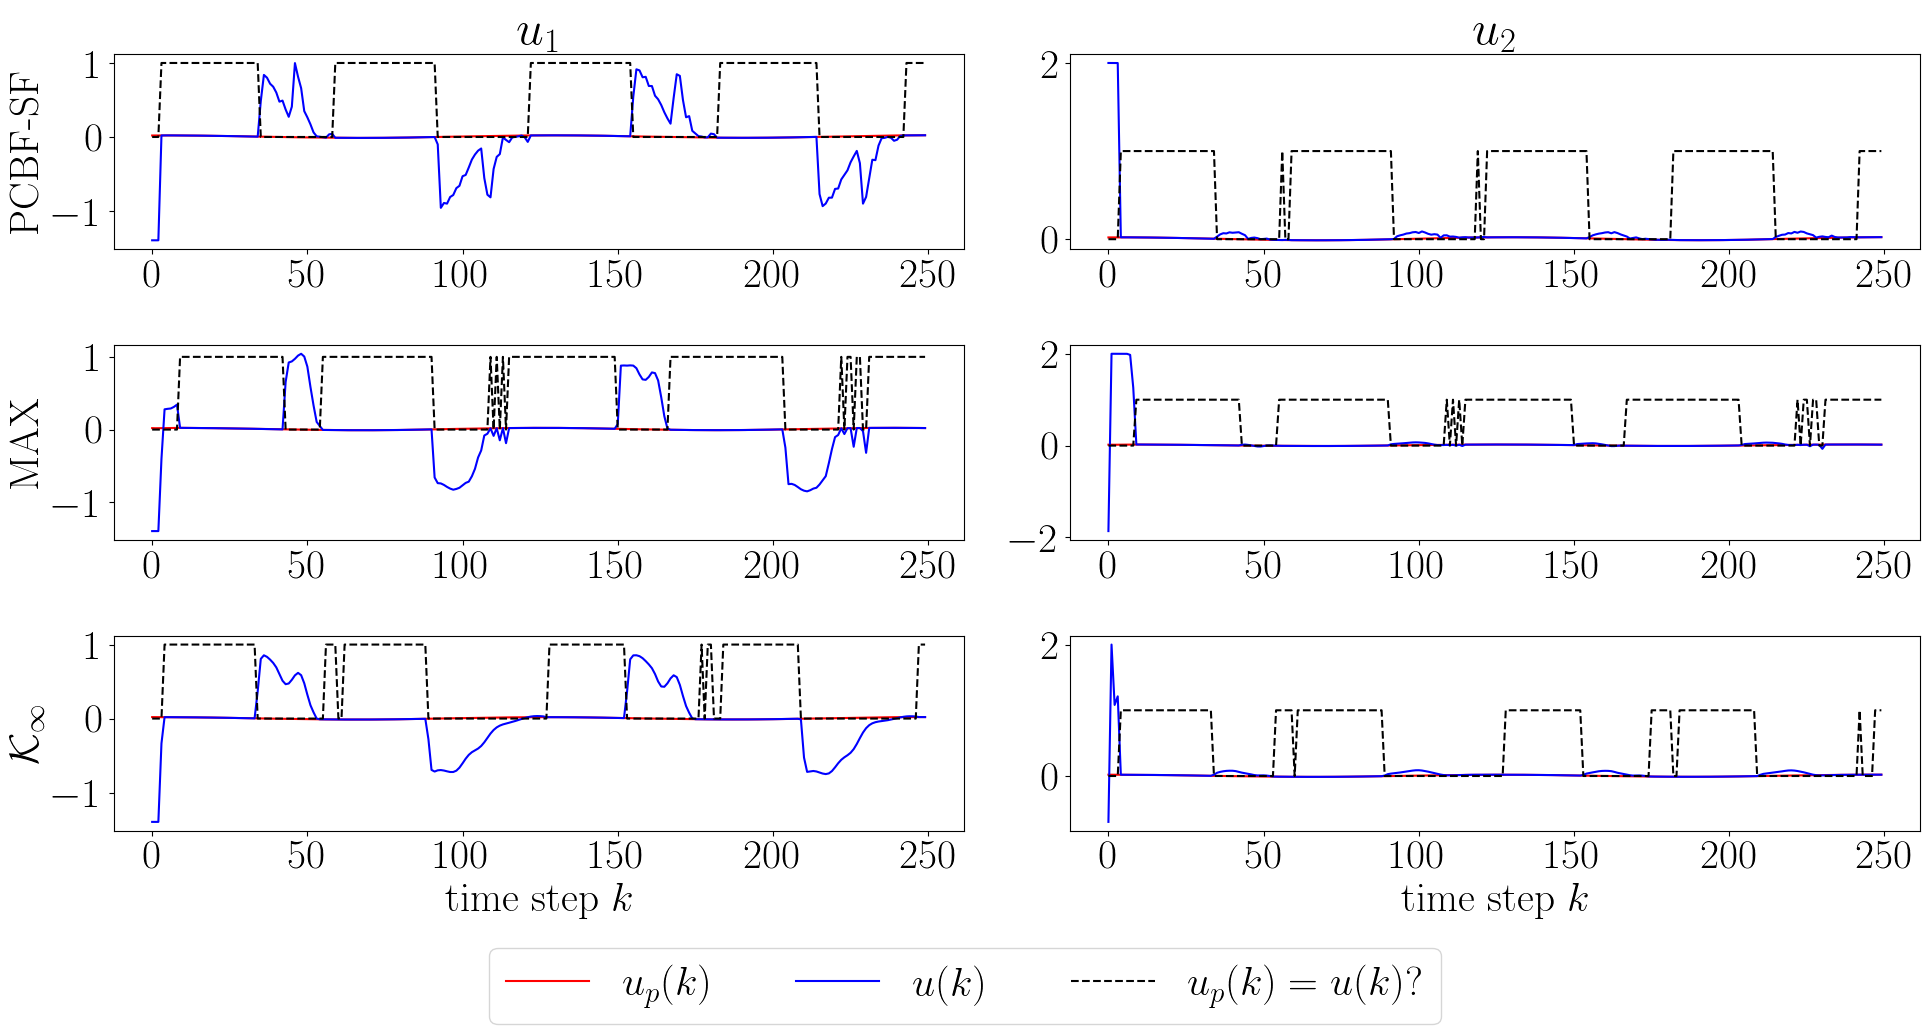

In [22]:
t = np.arange(N_steps)
fig, axs = plt.subplots(3,2)

# for ax in axs.flat:
#     ax.set(xlabel= 'time step $k$')
axs[2,0].set(xlabel= 'time step $k$')
axs[2,1].set(xlabel= 'time step $k$')

axs[0][0].set_ylabel('PCBF-SF')
axs[0][0].set_title('$u_1$')
axs[0][0].plot(t,u_p_1[:,0], label = '$u_$', color='red')
axs[0][0].plot(t,u_sim_1[:,0], label = '$u_p$', color='blue')
axs[0][0].plot(t,have_no_intervention[:, 0], label = 'interv', color='black', linestyle='dashed')

axs[0][1].set_title('$u_2$')
axs[0][1].plot(t,u_p_1[:,1], label = '$u_p$', color='red')
axs[0][1].plot(t,u_sim_1[:,1], label = '$u$', color='blue')#, linestyle="dashed")
axs[0][1].plot(t,have_no_intervention[:, 1], label = 'interv', color='black', linestyle='dashed')

axs[1][0].set_ylabel('MAX')
axs[1][0].plot(t,u_p_max_1[:,0], label = '$u_p$', color='red')
axs[1][0].plot(t,u_sim_max_1[:,0], label = '$u$', color='blue')
axs[1][0].plot(t,have_no_intervention_max[:, 0], label = 'interv', color='black', linestyle='dashed')

axs[1][1].plot(t,u_p_max_1[:,1], label = '$u_p$', color='red')
axs[1][1].plot(t,u_sim_max_1[:,1], label = '$u$', color='blue')
axs[1][1].plot(t,have_no_intervention_max[:, 1], label = 'interv', color='black', linestyle='dashed')

axs[2][0].set_ylabel('$\mathcal{K}_\infty$')
axs[2][0].plot(t,u_p_kinf_1[:,0], label = '$u_p(k)$', color='red')
axs[2][0].plot(t,u_sim_kinf_1[:,0], label = '$u(k)$', color='blue')
axs[2][0].plot(t,have_no_intervention_kinf[:, 0], label = '$u_p(k) = u(k) ?$', color='black', linestyle='dashed')

axs[2][1].plot(t,u_p_kinf_1[:,1], label = '$u_p$', color='red')
axs[2][1].plot(t,u_sim_kinf_1[:,1], label = '$u$', color='blue')#, linestyle="dashed")
axs[2][1].plot(t,have_no_intervention_kinf[:, 1], label = '$u_p = u ?$', color='black', linestyle='dashed')

# axs[2][0].legend(loc='lower center', bbox_to_anchor=(0.5, -2.15),
#           fancybox=True, shadow=True, ncol=3)

lines_labels = [axs[2][0].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
# plt.savefig(f"input_traj_u_{LOG_NAME}_{learned_controller_kinf.kinf_factor}.pdf")

## Distance performance input vs input from Approximate PCBF methods

/tmp/ipykernel_3886/2751437725.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


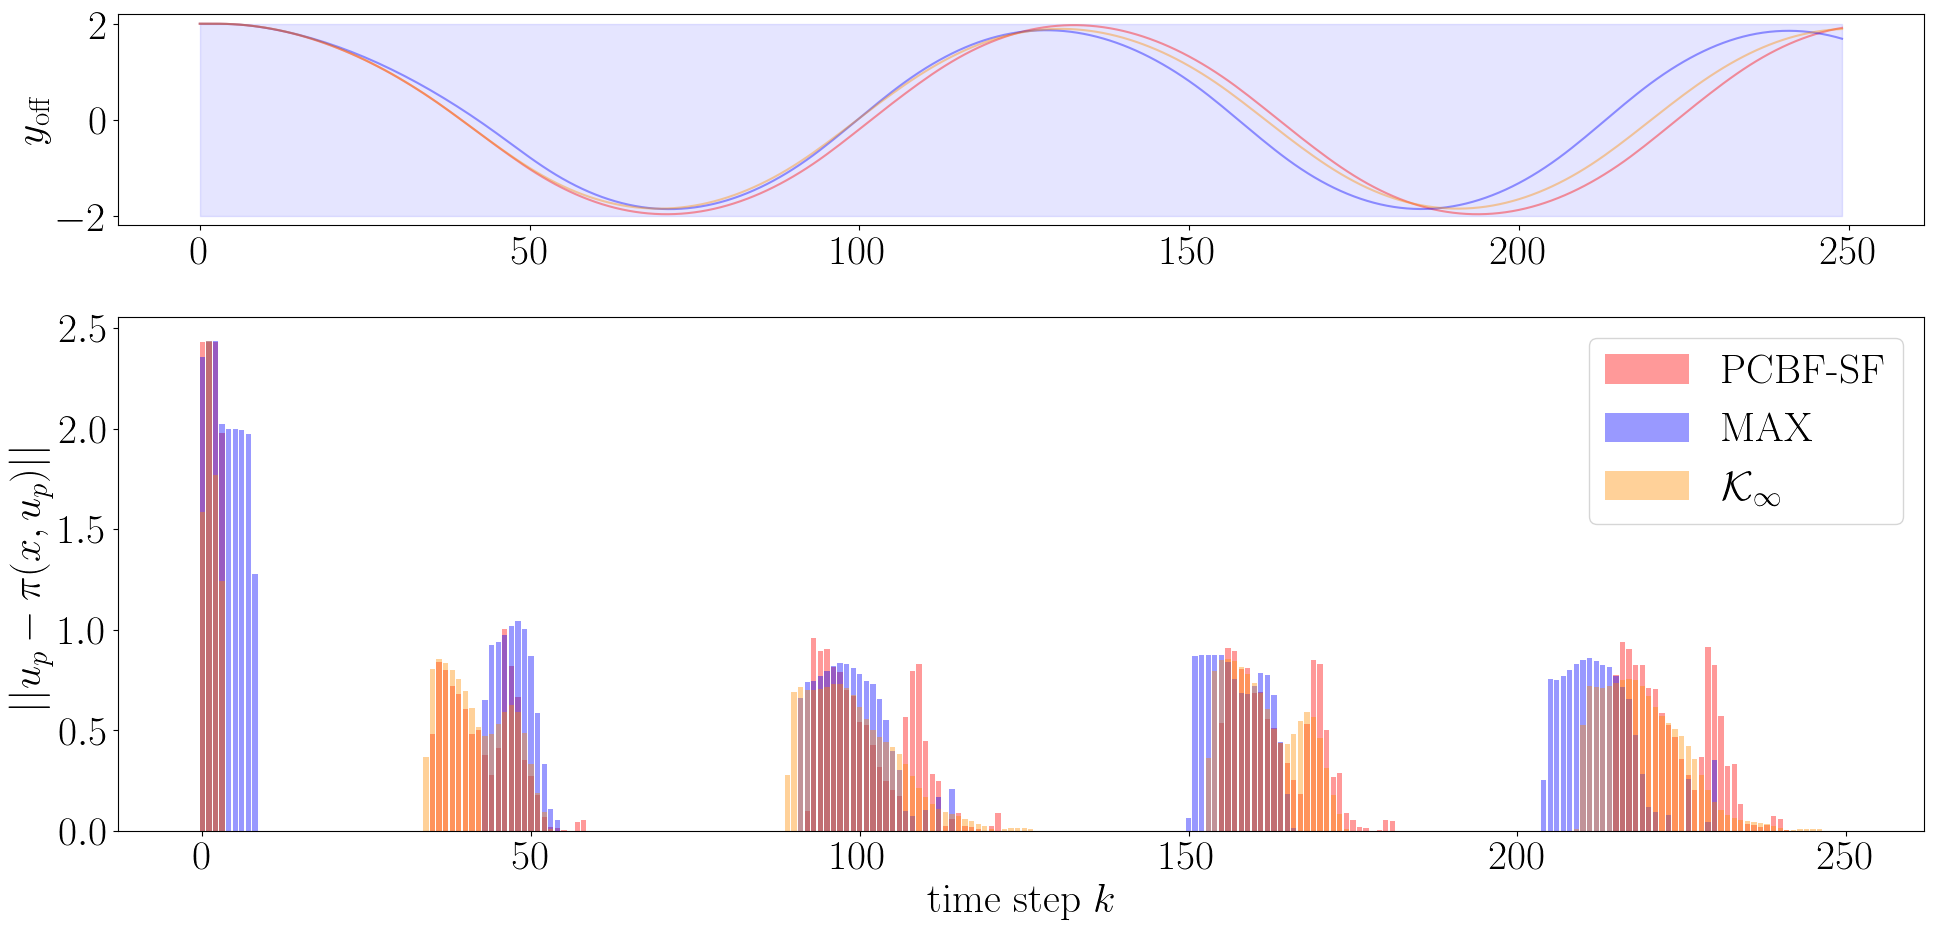

In [23]:
t = np.arange(N_steps)
constraint_color = (0, 120.0/256, 148.0/256)

axs = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    A
    B
    B
    """
)

axs["A"].plot(t, x_safe_1[:-1,0], label='PCBF-SF', color='red', alpha=0.4)
axs["A"].plot(t, x_safe_max_1[:-1,0], label='MAX', color='blue', alpha=0.4)
axs["A"].plot(t, x_safe_kinf_1[:-1,0], label='$\mathcal{K}_\infty$', color='darkorange', alpha=0.4)
axs["A"].set_ylabel('$y_{\mathrm{off}}$')
y = np.zeros_like(t)  
axs["A"].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
            
axs["B"].bar(t, norm_dev, label='PCBF-SF', color='red', alpha=0.4)
axs["B"].bar(t, norm_dev_max, label='MAX', color='blue', alpha=0.4)
axs["B"].bar(t, norm_dev_kinf, label='$\mathcal{K}_\infty$', color='darkorange', alpha=0.4)

axs["B"].set_xlabel('time step $k$')
axs["B"].set_ylabel('$||u_p - \pi(x,u_p)||$')
plt.legend()
plt.tight_layout()
# plt.savefig(f"input_norm_barplot_{LOG_NAME}_{learned_controller_kinf.kinf_factor}.pdf")

## Interventions distance for 10k sampled initial states

In [24]:
learned_controller_kinf_25 = APCBFSafetyFilterKINFDEC(model = model,m_type = model_type_name, use_log_space_model=use_log_space_model, 
                                                   use_plus_model = use_plus_models, params_dict = params_dict, sys= sys, input_constraints = U, 
                                                   performance_controller = bad_ctrl, verbose = False, kinf_factor=0.25, zero_tol=1e-8)
learned_controller_kinf_75 = APCBFSafetyFilterKINFDEC(model = model,m_type = model_type_name, use_log_space_model=use_log_space_model, 
                                                   use_plus_model = use_plus_models, params_dict = params_dict, sys= sys, input_constraints = U, 
                                                   performance_controller = bad_ctrl, verbose = False, kinf_factor=0.75, zero_tol=1e-8)
learned_controller_kinf_90 = APCBFSafetyFilterKINFDEC(model = model,m_type = model_type_name, use_log_space_model=use_log_space_model, 
                                                   use_plus_model = use_plus_models, params_dict = params_dict, sys= sys, input_constraints = U, 
                                                   performance_controller = bad_ctrl, verbose = False, kinf_factor=0.9, zero_tol=1e-8)

In [25]:
N_POINTS = int(1e4)
test_data = torch.load(
    '../data/val_data_813k_nonlinear.pt')
np.random.shuffle(test_data.X)
test_data_sel_x = test_data.X[:N_POINTS, :]

In [26]:
gen_pcbf = False #if want to generate pcbf values also (t > 20min)

In [27]:
# Generate
N_steps_2 = 1
if gen_pcbf:
    int_pcbf_counter = 0
    norm_pcbf_distance = 0.0

int_max_counter = 0
int_kinf_counter = 0

norm_max_distance = 0.0
norm_kinf_distance = 0.0

norm_kinf_distance_25 = 0.0
norm_kinf_distance_75 = 0.0
norm_kinf_distance_90 = 0.0

for i, x0 in enumerate(tqdm(test_data_sel_x)):
    if gen_pcbf:
        x_safe, u_sim = sim.simulate_discrete(x0, non_lin_disc, controller_object=pcbf_controller, Nsteps=N_steps_2)
    x_safe_max, u_sim_max = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_maxdec, Nsteps=N_steps_2)
    x_safe_kinf, u_sim_kinf = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_kinf, Nsteps=N_steps_2)
    x_safe_kinf_25, u_sim_kinf_25 = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_kinf_25, Nsteps=N_steps_2)
    x_safe_kinf_75, u_sim_kinf_75 = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_kinf_75, Nsteps=N_steps_2)
    x_safe_kinf_90, u_sim_kinf_90 = sim.simulate_discrete(x0, non_lin_disc, controller_object=learned_controller_kinf_90, Nsteps=N_steps_2)
    
    if gen_pcbf:
        _ , _,  num_int_pcbf, _, norm_dev_pcbf_1 = return_interventions(x_safe, u_sim, bad_ctrl)
    _, _, num_int_max, _, norm_dev_max_1 = return_interventions(x_safe_max, u_sim_max, bad_ctrl)
    _, _, num_int_kinf, _, norm_dev_kinf_1 = return_interventions(x_safe_kinf, u_sim_kinf, bad_ctrl)
    _, _, num_int_kinf_25, _, norm_dev_kinf_1_25 = return_interventions(x_safe_kinf_75, u_sim_kinf_25, bad_ctrl)
    _, _, num_int_kinf_75, _, norm_dev_kinf_1_75 = return_interventions(x_safe_kinf_75, u_sim_kinf_75, bad_ctrl)
    _, _, num_int_kinf_90, _, norm_dev_kinf_1_90 = return_interventions(x_safe_kinf_90, u_sim_kinf_90, bad_ctrl)
    
    if gen_pcbf:
        norm_pcbf_distance += norm_dev_pcbf_1
        int_pcbf_counter += num_int_pcbf
            
    norm_max_distance += norm_dev_max_1
    norm_kinf_distance += num_int_kinf
    norm_kinf_distance_25+= num_int_kinf_25
    norm_kinf_distance_75+= num_int_kinf_75
    norm_kinf_distance_90 += num_int_kinf_90
    

    int_max_counter += num_int_max
    int_kinf_counter += num_int_kinf

  0%|          | 0/10000 [00:00<?, ?it/s]

In [28]:
if gen_pcbf:
    with open('../data/input_interventions/pcbf_data.npy', 'wb') as f:
        np.save(f, norm_pcbf_distance)
        np.save(f, int_pcbf_counter)
else:
    with open('../data/input_interventions/pcbf_data.npy', 'rb') as f:
        norm_pcbf_distance = np.load(f)
        int_pcbf_counter = np.load(f)

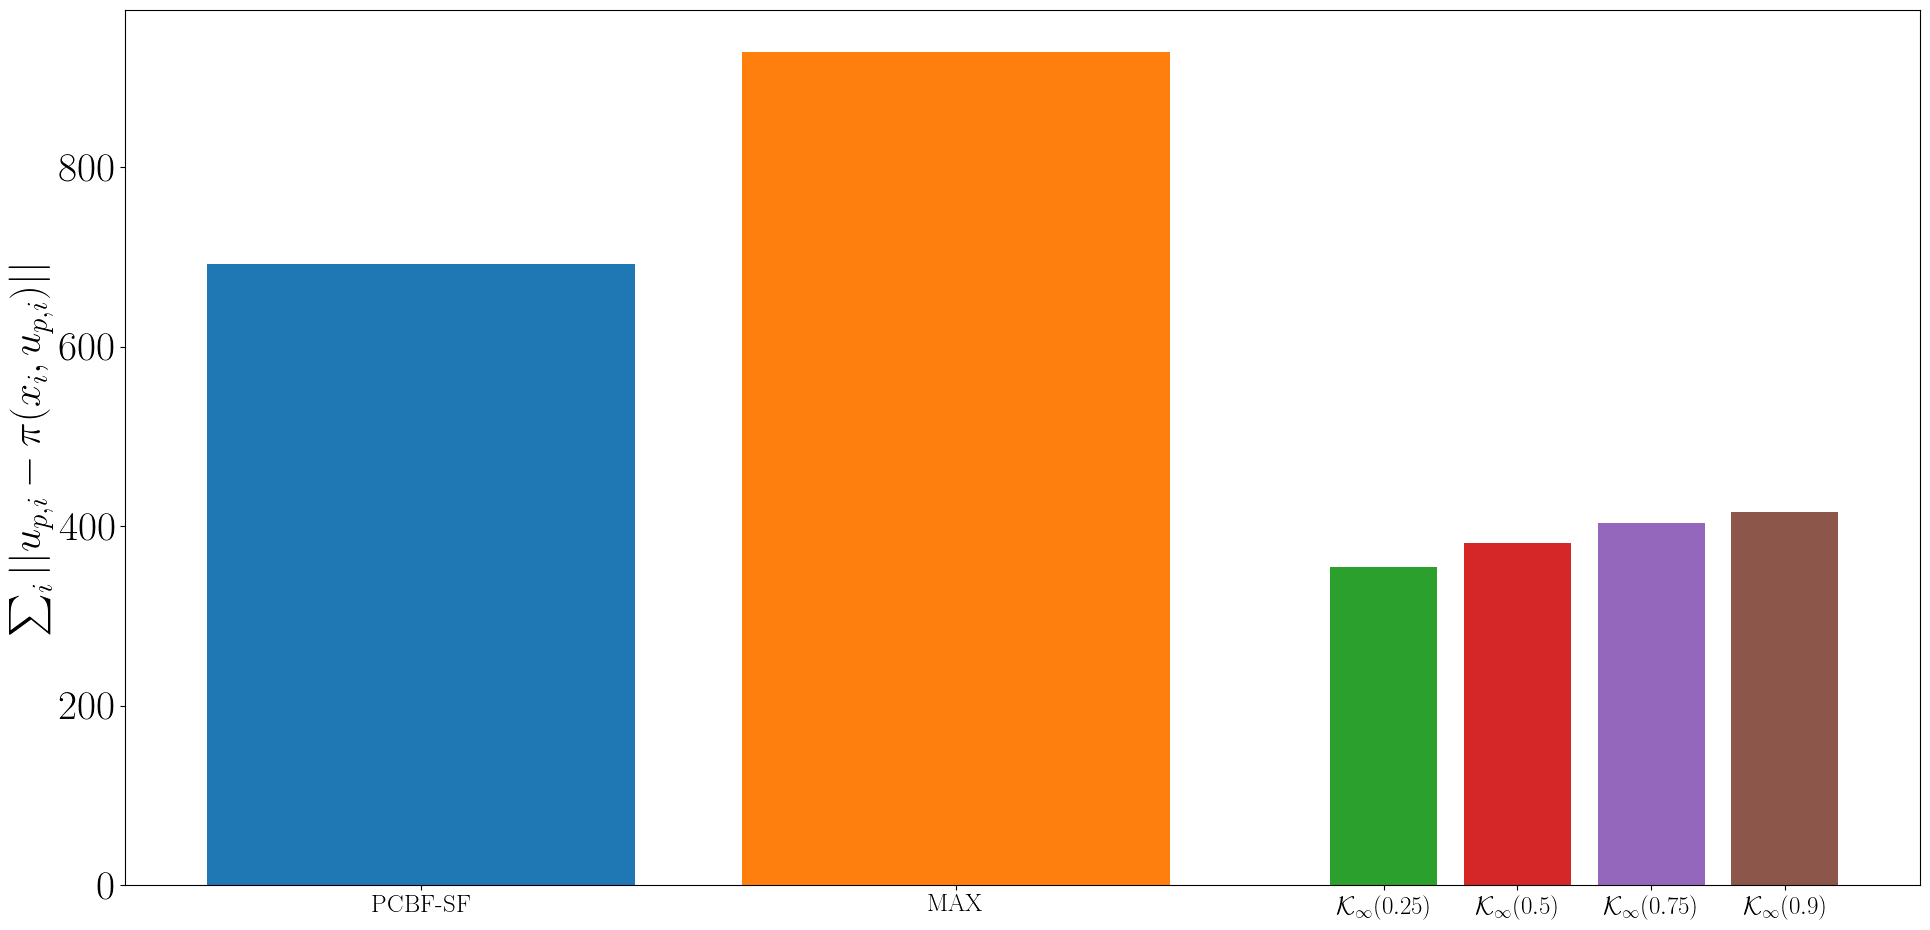

In [29]:
fig, ax = plt.subplots(1,1)
ax = [ax]
xticks_labels = ['PCBF-SF', 'MAX', '$\mathcal{K}_\infty(0.25)$', '$\mathcal{K}_\infty(0.5)$', '$\mathcal{K}_\infty(0.75)$', '$\mathcal{K}_\infty(0.9)$']
# counter_list = [int_pcbf_counter, int_max_counter, int_kinf_counter]
# perc_list = [np.array(val)/N_POINTS for val in counter_list]
dist_list = [norm_pcbf_distance, norm_max_distance, norm_kinf_distance_25, norm_kinf_distance, norm_kinf_distance_75, norm_kinf_distance_90]
var_idx_list = []
for i in range(2):
    ax[0].bar(i, dist_list[i][0])
    var_idx_list.append(i)
    # ax[1].bar(i, el[1])
    
for j in range(2,len(dist_list)):
    idx = 1.3+j*0.25
    var_idx_list.append(idx)
    ax[0].bar(idx, dist_list[j][0], width=0.2)
    
ax[0].set_ylabel("$\sum_i||u_{p,i} - \pi(x_i,u_{p,i})||$")
ax[0].set_xticks(var_idx_list,xticks_labels, rotation='horizontal', fontsize=18)
plt.tight_layout()
plt.savefig(f"interventions_sum_percentage_{LOG_NAME})_{learned_controller_kinf.kinf_factor}.pdf")

/tmp/ipykernel_3886/254092442.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


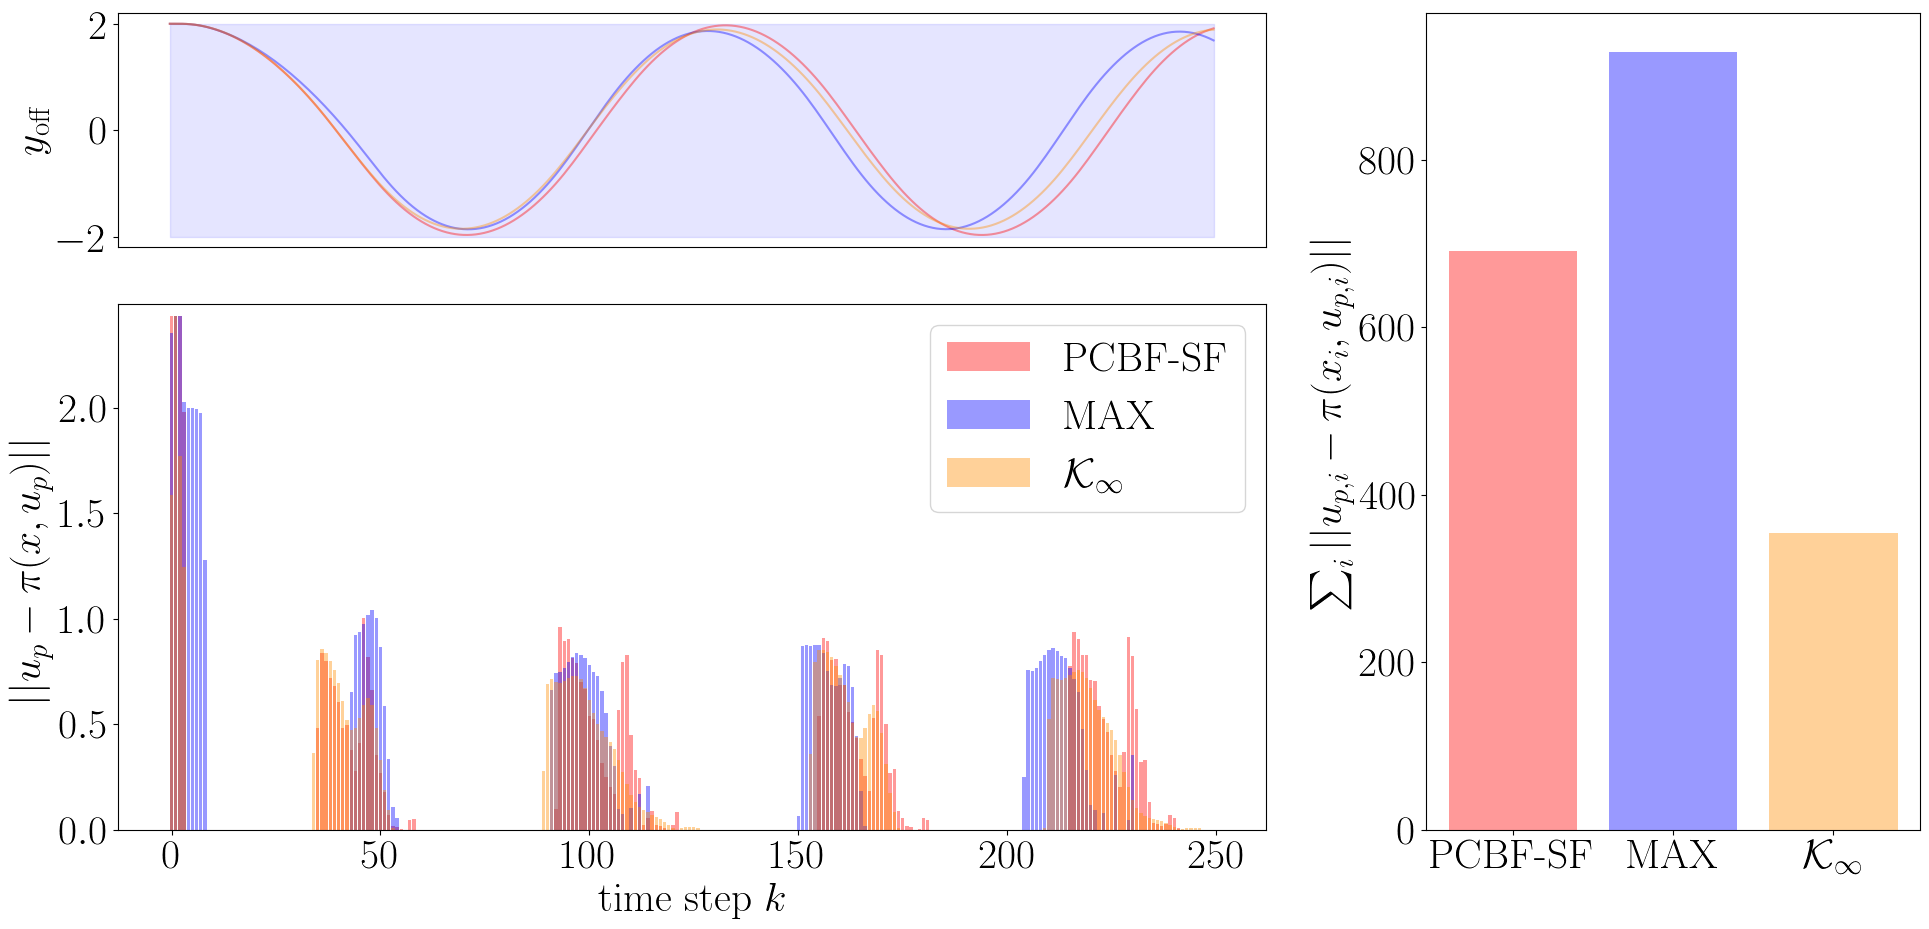

In [51]:
t = np.arange(N_steps)
#fig, axs = plt.subplots(2,1)
constraint_color = (0, 120.0/256, 148.0/256)
method_color = ['red', "blue", "darkorange"]
method_alpha = [0.4,0.4,0.4]

axs = plt.figure(constrained_layout=True).subplot_mosaic(
    """
    AAC
    BBC
    BBC
    """
)

axs["A"].plot(t, x_safe_1[:-1,0], label='PCBF-SF', color=method_color[0], alpha=method_alpha[0])
axs["A"].plot(t, x_safe_max_1[:-1,0], label='MAX', color=method_color[1], alpha=method_alpha[1])
axs["A"].plot(t, x_safe_kinf_1[:-1,0], label='$\mathcal{K}_\infty$', color=method_color[2], alpha=method_alpha[2])
axs["A"].set_ylabel('$y_{\mathrm{off}}$')
y = np.zeros_like(t)  
axs["A"].fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
            
axs["B"].bar(t, norm_dev, label='PCBF-SF', color='red', alpha=0.4)
axs["B"].bar(t, norm_dev_max, label='MAX', color='blue', alpha=0.4)
axs["B"].bar(t, norm_dev_kinf, label='$\mathcal{K}_\infty$', color='darkorange', alpha=0.4)
axs["B"].set_xlabel('time step $k$')
axs["B"].set_ylabel('$||u_p - \pi(x,u_p)||$')
plt.legend()

xticks_labels = ['PCBF-SF', 'MAX', '$\mathcal{K}_\infty$']
# counter_list = [int_pcbf_counter, int_max_counter, int_kinf_counter]
# perc_list = [np.array(val)/N_POINTS for val in counter_list]
dist_list = [norm_pcbf_distance, norm_max_distance, norm_kinf_distance, norm_kinf_distance_25,  norm_kinf_distance_75, norm_kinf_distance_90]
var_idx_list = []
for i in range(2): 
    axs["C"].bar(i, dist_list[i][0], color=method_color[i], alpha=method_alpha[i])
    var_idx_list.append(i)
    
var_idx_list.append(2)
axs["C"].bar(2, dist_list[3][0], color=method_color[2], alpha=method_alpha[i])
axs["C"].set_ylabel("$\sum_i||u_{p,i} - \pi(x_i,u_{p,i})||$")
axs["C"].set_xticks(var_idx_list,xticks_labels, rotation='horizontal', fontsize=30)
axs["A"].tick_params(axis='x', bottom=False, labelbottom=False)
axs["B"].set_ylim([0, 2.49])
fig.align_ylabels([axs["A"],axs["B"]])

plt.tight_layout()
# plt.savefig(f"combi_{LOG_NAME}_0.5.pdf")

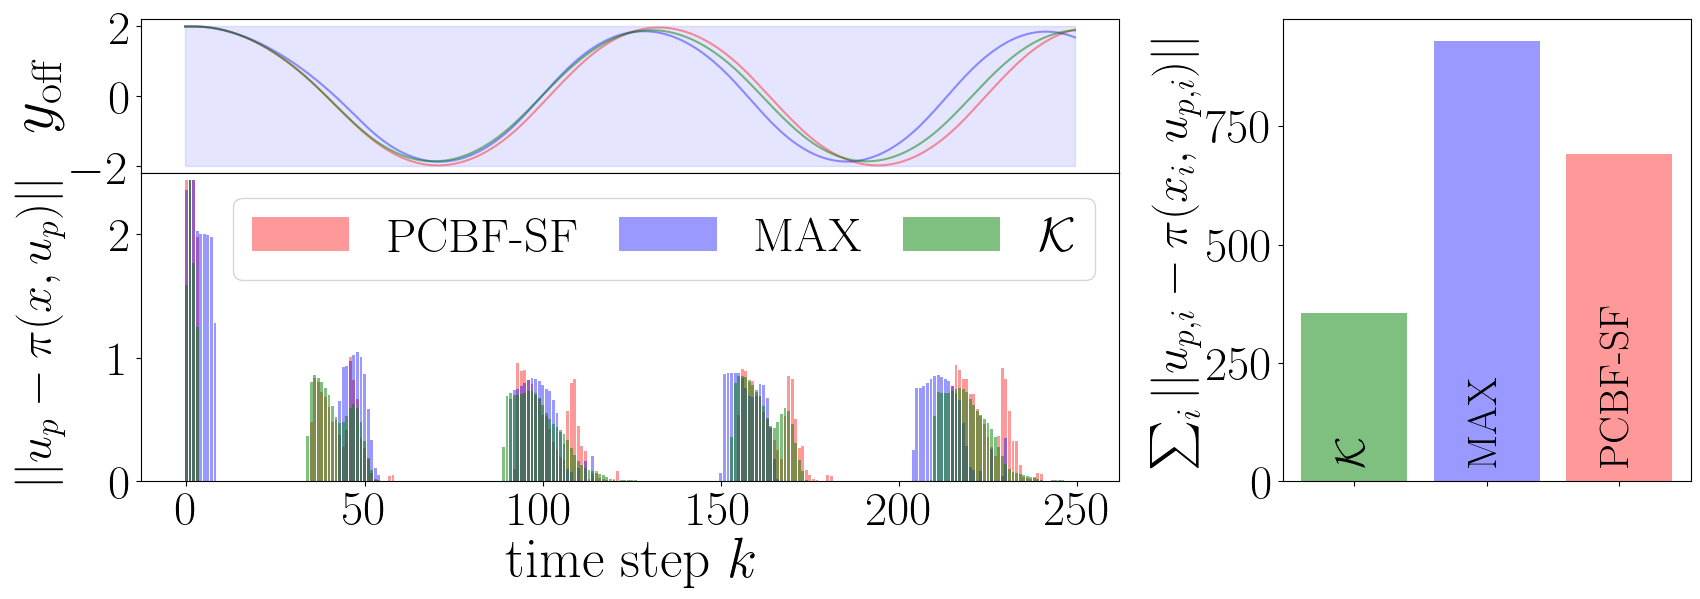

In [125]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 35})
plt.rc('text', usetex=True)

t = np.arange(N_steps)
#fig, axs = plt.subplots(2,1)
constraint_color = (0, 120.0/256, 148.0/256)
method_color = ['red', "blue", "green"]
method_alpha = [0.4,0.4,0.5]

fig = plt.figure()
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)


#axs = plt.figure(constrained_layout=True).subplot_mosaic(
#    """
#    AAC
#    BBC
#    BBC
#    """
#)

ax1.plot(t, x_safe_1[:-1,0], label='PCBF-SF', color=method_color[0], alpha=method_alpha[0])
ax1.plot(t, x_safe_max_1[:-1,0], label='MAX', color=method_color[1], alpha=method_alpha[1])
ax1.plot(t, x_safe_kinf_1[:-1,0], label='$\mathcal{K}$', color=method_color[2], alpha=method_alpha[2])
ax1.set_ylabel('$y_{\mathrm{off}}$', fontsize=45)
y = np.zeros_like(t)  
ax1.fill_between(t, (y-X.b[1]), (y+X.b[0]), color='blue', alpha=.1)
            
ax2.bar(t, norm_dev, label='PCBF-SF', color=method_color[0], alpha=method_alpha[0])
ax2.bar(t, norm_dev_max, label='MAX', color=method_color[1], alpha=method_alpha[1])
ax2.bar(t, norm_dev_kinf, label='$\mathcal{K}$', color=method_color[2], alpha=method_alpha[2])
ax2.set_xlabel('time step $k$', fontsize = 40)
ax2.set_ylabel('$||u_p - \pi(x,u_p)||$')
ax2.legend(ncol=3, columnspacing=0.8)

xticks_labels = ['$\mathcal{K}$', 'MAX', 'PCBF-SF']
# counter_list = [int_pcbf_counter, int_max_counter, int_kinf_counter]
# perc_list = [np.array(val)/N_POINTS for val in counter_list]
dist_list = [norm_pcbf_distance, norm_max_distance, norm_kinf_distance, norm_kinf_distance_25,  norm_kinf_distance_75, norm_kinf_distance_90]
var_idx_list = []

ax3.bar(1, dist_list[1][0], color=method_color[1], alpha=method_alpha[1])
var_idx_list.append(0)
ax3.bar(2, dist_list[0][0], color=method_color[0], alpha=method_alpha[0])
var_idx_list.append(1)

    
var_idx_list.append(2)
ax3.bar(0, dist_list[3][0], color=method_color[2], alpha=method_alpha[2])
ax3.set_ylabel("$\sum_i||u_{p,i} - \pi(x_i,u_{p,i})||$")
ax3.set_xticks(var_idx_list,xticks_labels, rotation='vertical',verticalalignment='bottom', position=[0.05,0.05], fontsize=30)
ax1.tick_params(axis='x', bottom=False, labelbottom=False)
ax2.set_ylim([0, 2.49])
fig.align_ylabels([ax1,ax2])


#plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.4)
plt.savefig(f'../plots/pdf/combi_{LOG_NAME}_0.5.pdf', bbox_inches='tight')